In [1]:
#获取UCF-101数据集中的所有文件
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('./UCF-101/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c01.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c02.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c03.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c04.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c05.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c06.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g02_c01.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g02_c02.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g02_c03.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g02_c04.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g03_c01.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g03_c02.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g03_c03.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g03_c04.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g03_c05.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g03_c06.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g04_c01.avi
./UCF-101/ApplyEyeMakeup\v_ApplyEyeMakeup_g04_c02.avi
./UCF-101/ApplyEyeMakeup\v_A

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
#查看视频标签及其分类数量
label_data = pd.read_csv("./ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
len(label_data)

101

In [4]:
#获取每个分类的路径信息，为接下来训练做准备
path = []
labels = label_data.labels.values
for label in labels:
    path.append('./UCF-101/{}/'.format(label))
path

['./UCF-101/ApplyEyeMakeup/',
 './UCF-101/ApplyLipstick/',
 './UCF-101/Archery/',
 './UCF-101/BabyCrawling/',
 './UCF-101/BalanceBeam/',
 './UCF-101/BandMarching/',
 './UCF-101/BaseballPitch/',
 './UCF-101/Basketball/',
 './UCF-101/BasketballDunk/',
 './UCF-101/BenchPress/',
 './UCF-101/Biking/',
 './UCF-101/Billiards/',
 './UCF-101/BlowDryHair/',
 './UCF-101/BlowingCandles/',
 './UCF-101/BodyWeightSquats/',
 './UCF-101/Bowling/',
 './UCF-101/BoxingPunchingBag/',
 './UCF-101/BoxingSpeedBag/',
 './UCF-101/BreastStroke/',
 './UCF-101/BrushingTeeth/',
 './UCF-101/CleanAndJerk/',
 './UCF-101/CliffDiving/',
 './UCF-101/CricketBowling/',
 './UCF-101/CricketShot/',
 './UCF-101/CuttingInKitchen/',
 './UCF-101/Diving/',
 './UCF-101/Drumming/',
 './UCF-101/Fencing/',
 './UCF-101/FieldHockeyPenalty/',
 './UCF-101/FloorGymnastics/',
 './UCF-101/FrisbeeCatch/',
 './UCF-101/FrontCrawl/',
 './UCF-101/GolfSwing/',
 './UCF-101/Haircut/',
 './UCF-101/Hammering/',
 './UCF-101/HammerThrow/',
 './UCF-101/H

In [5]:
#抓取数据集中视频的特征
def feature_extraction(video_path):
    width, height = [60, 60]
    sequence_length = 10
    frames_list = []
    #读取视频
    video_reader = cv2.VideoCapture(video_path)
    #获取视频中的帧数信息
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #计算将帧添加到列表的间隔
    skip_interval = max(int(frame_count/sequence_length), 1)
    #遍历视频帧
    for count in range(sequence_length):
        #设定当前帧在视频中的位置
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, count * skip_interval)
        #读取当前帧
        ret, frame = video_reader.read()
        if not ret:
            break;
        #重置画面大小
        frame = cv2.resize(frame, (height, width))
        frame = frame/255
        #添加帧
        frames_list.append(frame)
    video_reader.release()
    #输出帧序列
    return frames_list

In [6]:
#输入视频
def load_video(dataset):
    global image
    label_index = 0
    labels = []
    images = []
    #遍历每个类别对应的文件夹
    for folder in dataset:
        for file in tqdm(os.listdir(folder)):
            #获取每个视频的储存位置
            video_path = os.path.join(folder, file)
            #抓取视频帧
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index += 1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [7]:
#由于个人电脑性能，取前十个分类的视频进行判断
images, label = load_video(path[:10])

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:05<00:00, 28.83it/s]


In [8]:
images[0].shape

(10, 60, 60, 3)

In [9]:
#划分训练集/测试集
x_train, x_test, y_train, y_test = train_test_split(images, label, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((1291, 10, 60, 60, 3), (83, 10, 60, 60, 3), (1291,), (83,))

In [10]:
#构建训练模型（ConvLSTM）
model = Sequential()

model.add(BatchNormalization(momentum=0.8, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 10, 60, 60, 3)    12        
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 58, 58, 16)    11008     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 29, 29, 16)   0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 10, 29, 29, 16)   0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 27, 27, 16)    18496     
                                                        

In [11]:
#编译模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [12]:
#训练模型
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50
41/41 [==============================] - 485s 11s/step - loss: 2.6932 - accuracy: 0.3571 - val_loss: 1.6468 - val_accuracy: 0.4337
Epoch 2/50
41/41 [==============================] - 440s 11s/step - loss: 1.4470 - accuracy: 0.5593 - val_loss: 1.0384 - val_accuracy: 0.5783
Epoch 3/50
41/41 [==============================] - 438s 11s/step - loss: 0.8217 - accuracy: 0.7227 - val_loss: 0.8630 - val_accuracy: 0.7108
Epoch 4/50
41/41 [==============================] - 436s 11s/step - loss: 0.6361 - accuracy: 0.7839 - val_loss: 0.7207 - val_accuracy: 0.7349
Epoch 5/50
41/41 [==============================] - 433s 11s/step - loss: 0.5643 - accuracy: 0.8218 - val_loss: 0.9409 - val_accuracy: 0.6386
Epoch 6/50
41/41 [==============================] - 438s 11s/step - loss: 0.4228 - accuracy: 0.8505 - val_loss: 0.7886 - val_accuracy: 0.7590
Epoch 7/50
41/41 [==============================] - 448s 11s/step - loss: 0.3743 - accuracy: 0.8745 - val_loss: 0.6685 - val_accuracy: 0.7952
Epoch 

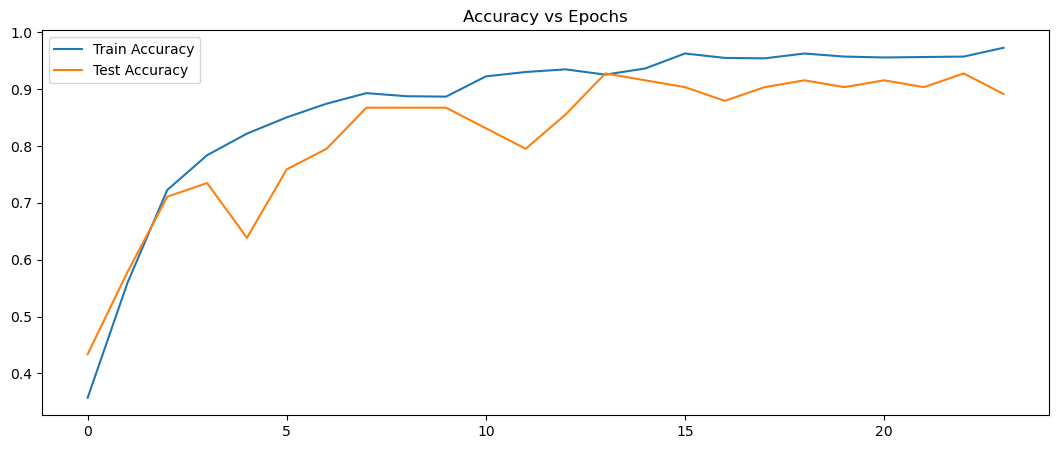

In [13]:
#准确率可视化
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [14]:
#进行模型预测
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

3/3 [==============================] - 6s 1s/step


In [15]:
#预测精度
accuracy_score(y_test, predicted_classes)

0.9156626506024096

In [ ]:
#进行预测验证
import random
plt.figure(figsize=(30,30))
#获取动作分类
classes_name = label_data.labels.values
#随机选择训练的10个分类中的5个分类
random_range = random.sample(range(len(classes_name[0:10])), 5)
#遍历所有的随机视频分类中的视频
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = classes_name[random_index]
    video_files_names_list = os.listdir(f'./UCF-101/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'./UCF-101/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    #展示视频信息
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')